<a href="https://colab.research.google.com/github/irojasga0721/Proyecto-de-grado/blob/main/Proyecto_de_grado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install "numpy<1.24" "pmdarima==2.0.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 62.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [6]:
import pandas as pd
import requests
from io import BytesIO

# --- IDs de los archivos compartidos en Google Drive ---
ID_DEMANDA = '1_z7pgh0LHKkG9pIfYsJuPPsjwgZiEbSR'
ID_PRECIPITACIONES = '1jjzoQZ-UHitWQVxdUm2AYrV1ReJICSRY'

# La URL base para la descarga directa
URL_BASE = 'https://drive.google.com/uc?id='

def cargar_excel_desde_drive(file_id, nombre_archivo):
    """Carga un archivo XLSX desde un ID de Google Drive a un DataFrame."""
    try:
        url_descarga = f'{URL_BASE}{file_id}&export=download'

        print(f"--- Cargando {nombre_archivo} ---")

        # Realizamos la petición para obtener el contenido binario del archivo
        response = requests.get(url_descarga)

        if response.status_code == 200:
            # FIX CLAVE: Se usa pd.read_excel para manejar el formato nativo XLSX
            # Usamos BytesIO porque la respuesta es binaria
            df = pd.read_excel(BytesIO(response.content))
            return df
        else:
            print(f"Error al descargar {nombre_archivo}. Código de estado: {response.status_code}")
            return None

    except Exception as e:
        print(f"Ocurrió un error al procesar {nombre_archivo}: {e}")
        return None

# =======================================================
# 1. Cargar Demanda de Energía
df_demanda = cargar_excel_desde_drive(ID_DEMANDA, "Demanda de Energía")

if df_demanda is not None:
    print("\nPrimeras 5 filas de Demanda de Energía:")
    print(df_demanda.head())
    print("\nInformación de Demanda de Energía:")
    df_demanda.info()

print("\n" + "="*70 + "\n")

# 2. Cargar Precipitaciones
df_precipitacion = cargar_excel_desde_drive(ID_PRECIPITACIONES, "Precipitaciones")

if df_precipitacion is not None:
    print("\nPrimeras 5 filas de Precipitaciones:")
    print(df_precipitacion.head())
    print("\nInformación de Precipitaciones:")
    df_precipitacion.info()

--- Cargando Demanda de Energía ---

Primeras 5 filas de Demanda de Energía:
        Fecha  Demanda Energia SIN kWh  Generación kWh  \
0  2010-01-01             1.154377e+08    1.154191e+08   
1  2010-01-02             1.276952e+08    1.276812e+08   
2  2010-01-03             1.236594e+08    1.236378e+08   
3  2010-01-04             1.444917e+08    1.459575e+08   
4  2010-01-05             1.491248e+08    1.521480e+08   

   Demanda No Atendida kWh  Exportaciones kWh  Importaciones kWh  
0                   1350.0            4536.91           21849.64  
1                   9450.0           12551.38           17079.39  
2                  13660.0            9118.35           17032.69  
3                  40460.0         1513370.10            7174.60  
4                  34440.0         3057651.95                NaN  

Información de Demanda de Energía:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 6 columns):
 #   Column                   

In [7]:
# df_demanda (Demanda de Energía)
# 1. Convertir la columna 'Fecha' a datetime
df_demanda['Fecha'] = pd.to_datetime(df_demanda['Fecha'])

# 2. Establecer 'Fecha' como índice
df_demanda = df_demanda.set_index('Fecha')

# 3. Remuestrear la demanda de frecuencia diaria ('D') a mensual ('M')
# Se usa 'MS' (Month Start) o 'M' (Month End). Usaremos 'MS' para la unificación.
# La demanda total mensual es la suma de los kWh diarios.
df_demanda_mensual = df_demanda['Demanda Energia SIN kWh'].resample('MS').sum().reset_index()

# Renombrar la columna de la variable objetivo
df_demanda_mensual = df_demanda_mensual.rename(columns={'Demanda Energia SIN kWh': 'Demanda_Mensual_kWh'})

print("--- Demanda Mensual (Primeras 5 filas) ---")
print(df_demanda_mensual.head())
print("\n--- Información de Demanda Mensual ---")
df_demanda_mensual.info()

--- Demanda Mensual (Primeras 5 filas) ---
       Fecha  Demanda_Mensual_kWh
0 2010-01-01         4.576941e+09
1 2010-02-01         4.409460e+09
2 2010-03-01         4.890121e+09
3 2010-04-01         4.610755e+09
4 2010-05-01         4.785909e+09

--- Información de Demanda Mensual ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Fecha                168 non-null    datetime64[ns]
 1   Demanda_Mensual_kWh  168 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB


In [8]:
# df_precipitacion (Precipitaciones)
# 1. Pivotar (melt) los meses a un formato largo
meses = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
df_precipitacion_largo = df_precipitacion.melt(
    id_vars=['AÑO'],
    value_vars=meses,
    var_name='MES',
    value_name='Precipitacion_mm'
)

# 2. Mapear nombres de meses a números
mapeo_meses = {mes.upper(): i + 1 for i, mes in enumerate(meses)}
df_precipitacion_largo['MES_NUM'] = df_precipitacion_largo['MES'].map(mapeo_meses)

# 3. Crear la columna de Fecha Mensual
# Usaremos el día 1 para que coincida con el remuestreo 'MS' de la demanda
df_precipitacion_largo['Fecha'] = pd.to_datetime(
    df_precipitacion_largo['AÑO'].astype(str) + '-' + df_precipitacion_largo['MES_NUM'].astype(str) + '-01'
)

# 4. Agregación Nacional (Promedio)
# Se calcula la precipitación media nacional por cada mes
df_precipitacion_mensual = df_precipitacion_largo.groupby('Fecha')['Precipitacion_mm'].mean().reset_index()

# La demanda energética depende de la generación hidroeléctrica, que a su vez depende de la precipitación.
# Un promedio puede ser una buena primera aproximación a la condición hídrica general.

print("\n" + "--- Precipitaciones Mensuales Agregadas (Primeras 5 filas) ---")
print(df_precipitacion_mensual.head())
print("\n--- Información de Precipitaciones Mensuales ---")
df_precipitacion_mensual.info()


--- Precipitaciones Mensuales Agregadas (Primeras 5 filas) ---
       Fecha  Precipitacion_mm
0 1919-01-01             177.6
1 1919-02-01              20.5
2 1919-03-01             101.6
3 1919-04-01             182.5
4 1919-05-01             145.7

--- Información de Precipitaciones Mensuales ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             1092 non-null   datetime64[ns]
 1   Precipitacion_mm  1092 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.2 KB


In [9]:
# df_final (Unificación)
# Fusión de la demanda y las precipitaciones por la columna 'Fecha'
df_final = pd.merge(df_demanda_mensual, df_precipitacion_mensual, on='Fecha', how='inner')

# Establecer la fecha como índice para el modelado de series de tiempo
df_final = df_final.set_index('Fecha')

# 4. Manejo de Nulos (Si hay)
# Después de la fusión y la agregación, es importante verificar si hay nulos
print("\n" + "--- Verificación de Valores Nulos en el DataFrame Final ---")
print(df_final.isnull().sum())

# Como paso de limpieza, eliminaremos filas con nulos si existen
df_final.dropna(inplace=True)

print("\n" + "="*70)
print("--- DataFrame Final para Modelización (Primeras y Últimas Filas) ---")
print(df_final.head())
print(df_final.tail())
print("\nRango de Fechas: ", df_final.index.min(), " a ", df_final.index.max())


--- Verificación de Valores Nulos en el DataFrame Final ---
Demanda_Mensual_kWh    0
Precipitacion_mm       0
dtype: int64

--- DataFrame Final para Modelización (Primeras y Últimas Filas) ---
            Demanda_Mensual_kWh  Precipitacion_mm
Fecha                                            
2010-01-01         4.576941e+09         12.158871
2010-02-01         4.409460e+09         32.220968
2010-03-01         4.890121e+09         37.288710
2010-04-01         4.610755e+09        198.346774
2010-05-01         4.785909e+09        169.119355
            Demanda_Mensual_kWh  Precipitacion_mm
Fecha                                            
2019-08-01         6.256798e+09               0.0
2019-09-01         6.050144e+09               0.0
2019-10-01         6.092439e+09               0.0
2019-11-01         5.979344e+09               0.0
2019-12-01         6.213363e+09               0.0

Rango de Fechas:  2010-01-01 00:00:00  a  2019-12-01 00:00:00


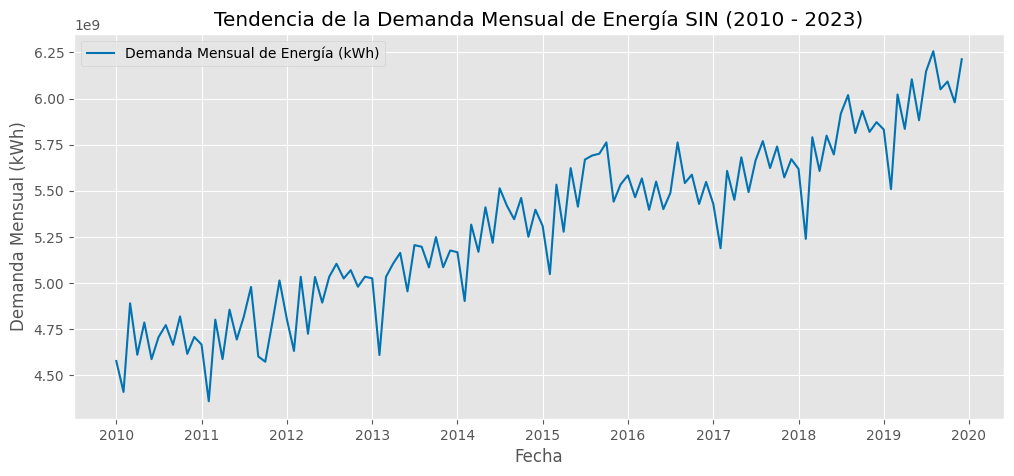

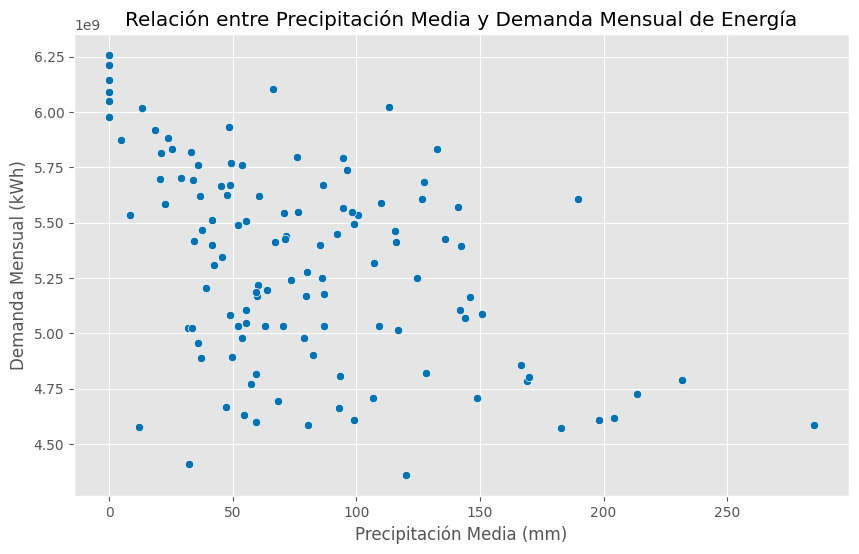


Coeficiente de Correlación (Demanda vs. Precipitación): -0.4519


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración básica para los gráficos
plt.style.use('ggplot')
sns.set_palette("colorblind")

# --- Gráfico 1: Demanda de Energía a través del tiempo ---
plt.figure(figsize=(12, 5))
plt.plot(df_final.index, df_final['Demanda_Mensual_kWh'], label='Demanda Mensual de Energía (kWh)')
plt.title('Tendencia de la Demanda Mensual de Energía SIN (2010 - 2023)')
plt.xlabel('Fecha')
plt.ylabel('Demanda Mensual (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# --- Gráfico 2: Precipitación vs. Demanda (Correlación) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Precipitacion_mm', y='Demanda_Mensual_kWh', data=df_final)
plt.title('Relación entre Precipitación Media y Demanda Mensual de Energía')
plt.xlabel('Precipitación Media (mm)')
plt.ylabel('Demanda Mensual (kWh)')
plt.show()

# --- Cálculo de Correlación ---
correlacion = df_final['Demanda_Mensual_kWh'].corr(df_final['Precipitacion_mm'])
print(f"\nCoeficiente de Correlación (Demanda vs. Precipitación): {correlacion:.4f}")

In [11]:
# Reutilizamos df_demanda (asumiendo que tiene las columnas 'Fecha' y 'Generación kWh')

# 1. Remuestreo de la Generación (Diaria a Mensual)
# Asegúrate de que df_demanda ya tiene 'Fecha' como índice datetime para el resample
df_generacion_mensual = df_demanda['Generación kWh'].resample('MS').sum().reset_index()
df_generacion_mensual = df_generacion_mensual.rename(columns={'Generación kWh': 'Generacion_Mensual_kWh'})

# 2. Fusión con el DataFrame final (Demanda y Precipitación)
# Solo fusionaremos el periodo que tiene datos de precipitación (hasta 2020)
df_final = pd.merge(df_final.reset_index(), df_generacion_mensual, on='Fecha', how='inner').set_index('Fecha')

# 3. Creación de una variable de "Brecha" o "Equilibrio" (opcional pero interesante)
df_final['Brecha_Demanda_Generacion'] = df_final['Demanda_Mensual_kWh'] - df_final['Generacion_Mensual_kWh']

print("--- DataFrame con Generación y Brecha (Muestra) ---")
print(df_final.head())

--- DataFrame con Generación y Brecha (Muestra) ---
            Demanda_Mensual_kWh  Precipitacion_mm  Generacion_Mensual_kWh  \
Fecha                                                                       
2010-01-01         4.576941e+09         12.158871            4.617623e+09   
2010-02-01         4.409460e+09         32.220968            4.410514e+09   
2010-03-01         4.890121e+09         37.288710            4.887825e+09   
2010-04-01         4.610755e+09        198.346774            4.607225e+09   
2010-05-01         4.785909e+09        169.119355            4.781791e+09   

            Brecha_Demanda_Generacion  
Fecha                                  
2010-01-01              -4.068239e+07  
2010-02-01              -1.054203e+06  
2010-03-01               2.295882e+06  
2010-04-01               3.529726e+06  
2010-05-01               4.118366e+06  


In [12]:
# --- 4. Variables Lag de Generación (1, 3 y 12 meses) ---
df_final['Generacion_lag_1'] = df_final['Generacion_Mensual_kWh'].shift(1)
df_final['Generacion_lag_3'] = df_final['Generacion_Mensual_kWh'].shift(3)
df_final['Generacion_lag_12'] = df_final['Generacion_Mensual_kWh'].shift(12)

# Se deben recalcular las variables lag para la "Brecha" si se usan
df_final['Brecha_lag_1'] = df_final['Brecha_Demanda_Generacion'].shift(1)


# Eliminar las filas iniciales que contendrán valores NaN debido a los lags
df_final.dropna(inplace=True)

print("\n" + "--- DataFrame Final con Características de Generación Lag ---")
print(df_final.head())


--- DataFrame Final con Características de Generación Lag ---
            Demanda_Mensual_kWh  Precipitacion_mm  Generacion_Mensual_kWh  \
Fecha                                                                       
2011-01-01         4.666630e+09         47.224590            4.842566e+09   
2011-02-01         4.359000e+09        119.950000            4.480266e+09   
2011-03-01         4.801205e+09        169.869672            5.052470e+09   
2011-04-01         4.587453e+09        285.063115            4.681036e+09   
2011-05-01         4.855477e+09        166.465574            4.922134e+09   

            Brecha_Demanda_Generacion  Generacion_lag_1  Generacion_lag_3  \
Fecha                                                                       
2011-01-01              -1.759364e+08      4.895156e+09      4.923329e+09   
2011-02-01              -1.212659e+08      4.842566e+09      4.812763e+09   
2011-03-01              -2.512651e+08      4.480266e+09      4.895156e+09   
2011-04-01  

In [13]:
# --- División de Datos (Corte temporal) ---
fecha_corte = '2020-01-01'

# Conjunto de Entrenamiento (Train): Antes de la fecha de corte
df_train = df_final[df_final.index < fecha_corte]

# Conjunto de Prueba (Test): A partir de la fecha de corte
df_test = df_final[df_final.index >= fecha_corte]

# Definir la variable objetivo (Y) y las variables predictoras (X)
# EXCLUIMOS la Generación_Mensual_kWh ya que es una variable endógena (no se conoce al momento de predecir)
# Pero SÍ incluimos sus LAGS, que son conocidos.
variables_excluir = ['Demanda_Mensual_kWh', 'Generacion_Mensual_kWh', 'Brecha_Demanda_Generacion']

X_train = df_train.drop(variables_excluir, axis=1)
Y_train = df_train['Demanda_Mensual_kWh']

X_test = df_test.drop(variables_excluir, axis=1)
Y_test = df_test['Demanda_Mensual_kWh']

print("\n" + "="*70)
print(f"Datos de Entrenamiento: {len(X_train)} registros (hasta {X_train.index.max().date()})")
print(f"Datos de Prueba (2020): {len(X_test)} registros (hasta {X_test.index.max().date()})")
print(f"\nNuevas Variables Predictoras (X): {list(X_train.columns)}")


Datos de Entrenamiento: 108 registros (hasta 2019-12-01)
Datos de Prueba (2020): 0 registros (hasta NaT)

Nuevas Variables Predictoras (X): ['Precipitacion_mm', 'Generacion_lag_1', 'Generacion_lag_3', 'Generacion_lag_12', 'Brecha_lag_1']


--- Diagnóstico del DataFrame Final (df_final) ---
Número total de filas: 108
Fecha mínima: 2011-01-01
Fecha máxima: 2019-12-01

⚠️ ALERTA: Los datos terminan en 2019. Se ajusta el corte a 2019-01-01 para usar el año 2019 como PRUEBA.

--- Diagnóstico de la División Final ---
Datos de Entrenamiento (Train): 96 registros (hasta 2018-12-01)
Datos de Prueba (Test): 12 registros (desde 2019-01-01 hasta 2019-12-01)

--- Continuando con el entrenamiento del Random Forest ---

✅ Random Forest - Resultados de Evaluación
   Período de Prueba: 2019-2019
   MAE (Error Absoluto Medio): 197,227,804 kWh
   RMSE (Raíz del Error Cuadrático Medio): 241,502,393 kWh
   R² (Coeficiente de Determinación): -0.5040


/tmp/ipython-input-3759742397.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancia.values, y=importancia.index, palette="viridis")


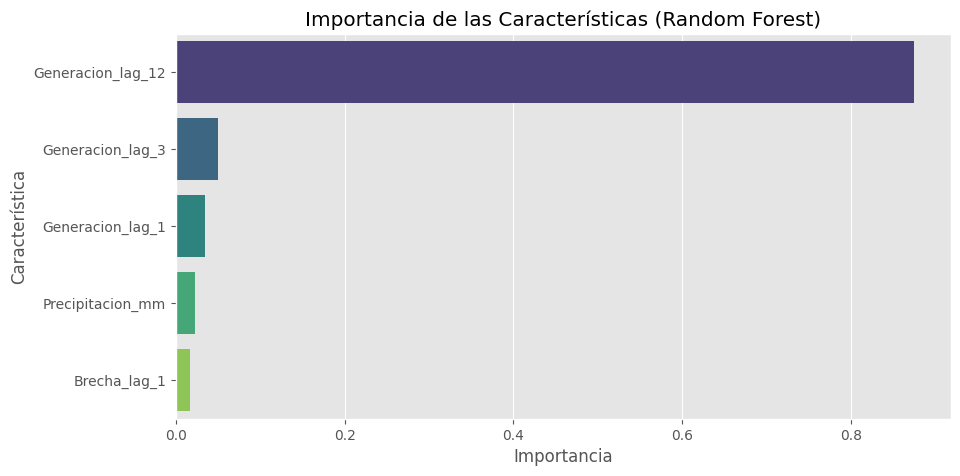

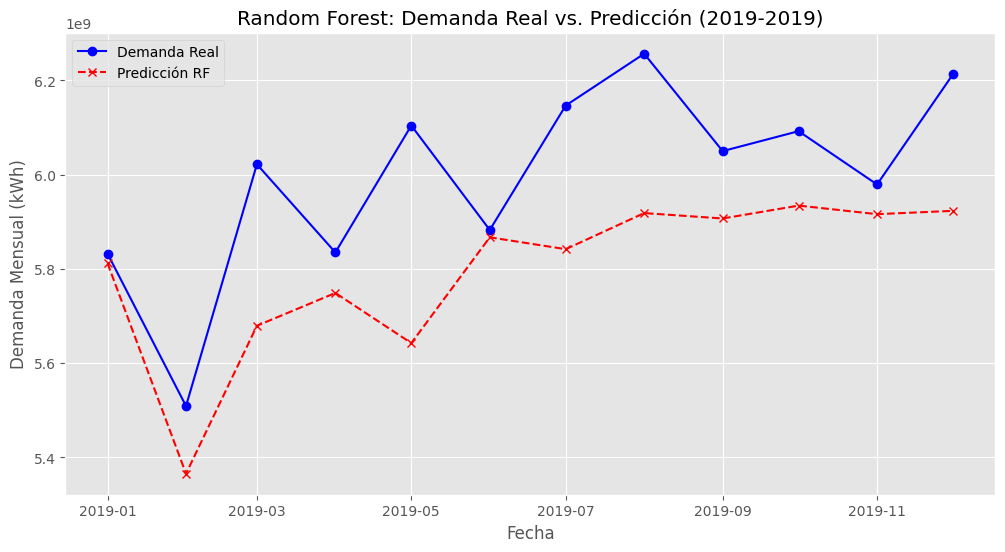

Gráficos de resultados guardados: rf_feature_importance.png y rf_predictions.png.


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asume que df_final es el DataFrame unificado (Demanda, Precipitación, Generación y Lags)
# Si no lo tienes definido, debes ejecutar nuevamente los pasos de preparación.

# --- 1. Diagnóstico del DataFrame Final (df_final) ---
print("--- Diagnóstico del DataFrame Final (df_final) ---")
if 'df_final' in locals() and not df_final.empty:
    print(f"Número total de filas: {len(df_final)}")
    print(f"Fecha mínima: {df_final.index.min().date()}")
    print(f"Fecha máxima: {df_final.index.max().date()}")

    ultima_fecha = df_final.index.max()

    # Sugerimos tomar el año anterior completo como conjunto de prueba
    if ultima_fecha.year < 2020:
        # Si el dato más reciente es 2019 (o anterior), usamos 2019 como test
        fecha_corte = f'{ultima_fecha.year}-01-01'
        print(f"\n⚠️ ALERTA: Los datos terminan en {ultima_fecha.year}. Se ajusta el corte a {fecha_corte} para usar el año {ultima_fecha.year} como PRUEBA.")
    else:
        # Mantenemos el corte original si el dato más reciente es 2020 o posterior
        fecha_corte = '2020-01-01'

else:
    print("❌ ERROR: La variable df_final no está definida. Por favor, ejecuta los pasos 2 y 4 nuevamente.")
    # Detenemos la ejecución si df_final no existe.
    raise NameError("La variable df_final no está definida. Revisa la ejecución de pasos anteriores.")


# --- 2. Re-división de Datos (Ajustada) ---

# Conjunto de Entrenamiento (Train): Antes de la fecha de corte
df_train = df_final[df_final.index < fecha_corte]

# Conjunto de Prueba (Test): A partir de la fecha de corte
df_test = df_final[df_final.index >= fecha_corte]

# Definir la variable objetivo (Y) y las variables predictoras (X)
variables_excluir = ['Demanda_Mensual_kWh', 'Generacion_Mensual_kWh', 'Brecha_Demanda_Generacion']

X_train = df_train.drop(variables_excluir, axis=1)
Y_train = df_train['Demanda_Mensual_kWh']

X_test = df_test.drop(variables_excluir, axis=1)
Y_test = df_test['Demanda_Mensual_kWh']

print("\n--- Diagnóstico de la División Final ---")
print(f"Datos de Entrenamiento (Train): {len(X_train)} registros (hasta {X_train.index.max().date()})")
print(f"Datos de Prueba (Test): {len(X_test)} registros (desde {X_test.index.min().date()} hasta {X_test.index.max().date()})")


# --- 3. Ejecución del Random Forest (Solo si X_test no está vacío) ---
if len(X_test) > 0:
    print("\n--- Continuando con el entrenamiento del Random Forest ---")

    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, Y_train)
    Y_pred_rf = rf_model.predict(X_test)

    # Evaluación
    mae_rf = mean_absolute_error(Y_test, Y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(Y_test, Y_pred_rf))
    r2_rf = r2_score(Y_test, Y_pred_rf)

    periodo_test = f"{X_test.index.min().year}-{X_test.index.max().year}"

    print("\n" + "="*70)
    print("✅ Random Forest - Resultados de Evaluación")
    print(f"   Período de Prueba: {periodo_test}")
    print(f"   MAE (Error Absoluto Medio): {mae_rf:,.0f} kWh")
    print(f"   RMSE (Raíz del Error Cuadrático Medio): {rmse_rf:,.0f} kWh")
    print(f"   R² (Coeficiente de Determinación): {r2_rf:.4f}")
    print("="*70)

    # Gráfico de Importancia de Características
    importancia = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=importancia.values, y=importancia.index, palette="viridis")
    plt.title('Importancia de las Características (Random Forest)')
    plt.xlabel('Importancia')
    plt.ylabel('Característica')
    plt.savefig('rf_feature_importance.png')

    plt.show()

    # Gráfico de Predicciones
    df_resultados_rf = pd.DataFrame({
        'Real': Y_test,
        'Predicción RF': Y_pred_rf
    }, index=Y_test.index)

    plt.figure(figsize=(12, 6))
    plt.plot(df_resultados_rf.index, df_resultados_rf['Real'], label='Demanda Real', marker='o', linestyle='-', color='blue')
    plt.plot(df_resultados_rf.index, df_resultados_rf['Predicción RF'], label='Predicción RF', marker='x', linestyle='--', color='red')
    plt.title(f'Random Forest: Demanda Real vs. Predicción ({periodo_test})')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda Mensual (kWh)')
    plt.legend()
    plt.grid(True)
    plt.savefig('rf_predictions.png')

    plt.show()

    print("Gráficos de resultados guardados: rf_feature_importance.png y rf_predictions.png.")

else:
    print("\n❌ El modelo no se pudo ejecutar. El conjunto de prueba ajustado sigue estando vacío. Por favor, confirma el rango de fechas del DataFrame final manualmente.")

--- Entrenando Gradient Boosting Regressor ---

✅ Gradient Boosting - Resultados de Evaluación (Conjunto de Prueba 2019)
   MAE (Error Absoluto Medio): 201,780,417 kWh
   RMSE (Raíz del Error Cuadrático Medio): 243,981,375 kWh
   R² (Coeficiente de Determinación): -0.5350


/tmp/ipython-input-1698642601.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancia_gbm.values, y=importancia_gbm.index, palette="mako")


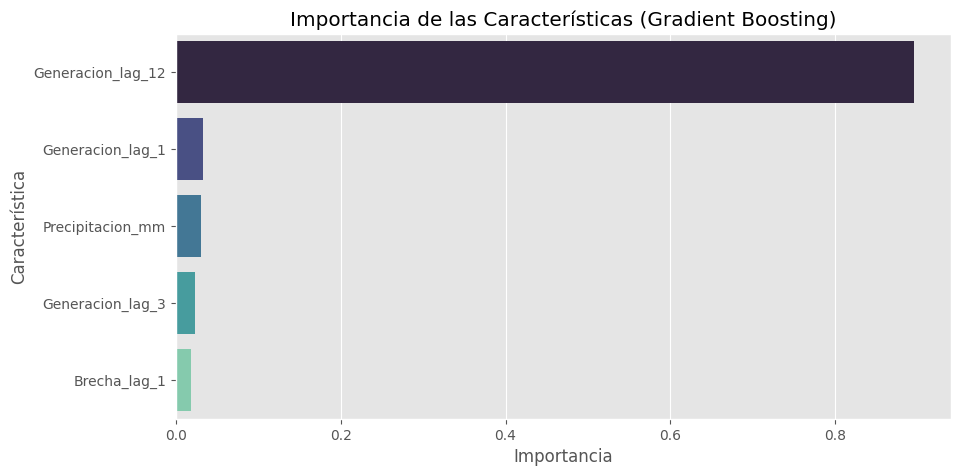

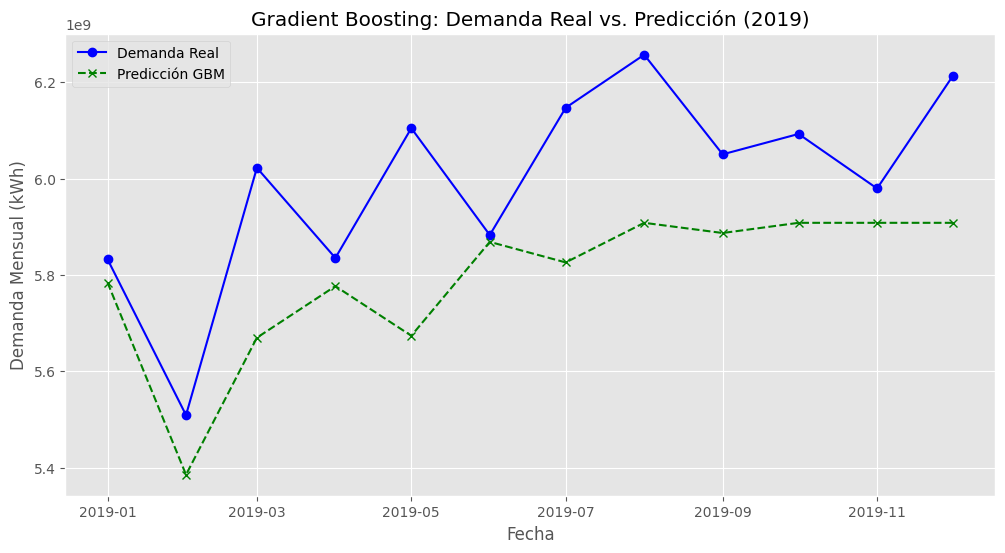

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Línea Mágica para forzar la visualización en Colab/Jupyter Notebooks
%matplotlib inline

# --- 1. Definición y Entrenamiento del Modelo ---
print("--- Entrenando Gradient Boosting Regressor ---")

# Parámetros iniciales.
gbm_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

# Se usan los DataFrames ya corregidos de Entrenamiento (hasta 2018)
gbm_model.fit(X_train, Y_train)

# --- 2. Predicción en el Conjunto de Prueba (2019) ---
Y_pred_gbm = gbm_model.predict(X_test)

# --- 3. Evaluación del Desempeño ---
mae_gbm = mean_absolute_error(Y_test, Y_pred_gbm)
rmse_gbm = np.sqrt(mean_squared_error(Y_test, Y_pred_gbm))
r2_gbm = r2_score(Y_test, Y_pred_gbm)
periodo_test = f"{X_test.index.min().year}"

print("\n" + "="*70)
print("✅ Gradient Boosting - Resultados de Evaluación (Conjunto de Prueba 2019)")
print(f"   MAE (Error Absoluto Medio): {mae_gbm:,.0f} kWh")
print(f"   RMSE (Raíz del Error Cuadrático Medio): {rmse_gbm:,.0f} kWh")
print(f"   R² (Coeficiente de Determinación): {r2_gbm:.4f}")
print("="*70)

# --- 4. Visualización de la Importancia de las Características ---
importancia_gbm = pd.Series(gbm_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=importancia_gbm.values, y=importancia_gbm.index, palette="mako")
plt.title('Importancia de las Características (Gradient Boosting)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show() # Muestra el gráfico 1

# --- 5. Visualización de las Predicciones ---
df_resultados_gbm = pd.DataFrame({
    'Real': Y_test,
    'Predicción GBM': Y_pred_gbm
}, index=Y_test.index)

plt.figure(figsize=(12, 6))
plt.plot(df_resultados_gbm.index, df_resultados_gbm['Real'], label='Demanda Real', marker='o', linestyle='-', color='blue')
plt.plot(df_resultados_gbm.index, df_resultados_gbm['Predicción GBM'], label='Predicción GBM', marker='x', linestyle='--', color='green')
plt.title(f'Gradient Boosting: Demanda Real vs. Predicción ({periodo_test})')
plt.xlabel('Fecha')
plt.ylabel('Demanda Mensual (kWh)')
plt.legend()
plt.grid(True)
plt.show() # Muestra el gráfico 2


--- 1. INICIANDO CARGA Y PREPARACIÓN DE DATOS ---
--- Cargando Demanda de Energía desde Drive ---
--- Cargando Precipitaciones desde Drive ---

--- Datos y Conjuntos de Entrenamiento/Prueba definidos con éxito. ---
✅ ARIMA BÁSICO - EVALUACIÓN 2021-2023 (Largo Plazo)
   MAE: 385,526,136 kWh
   RMSE: 453,326,467 kWh
   R²: -1.0964


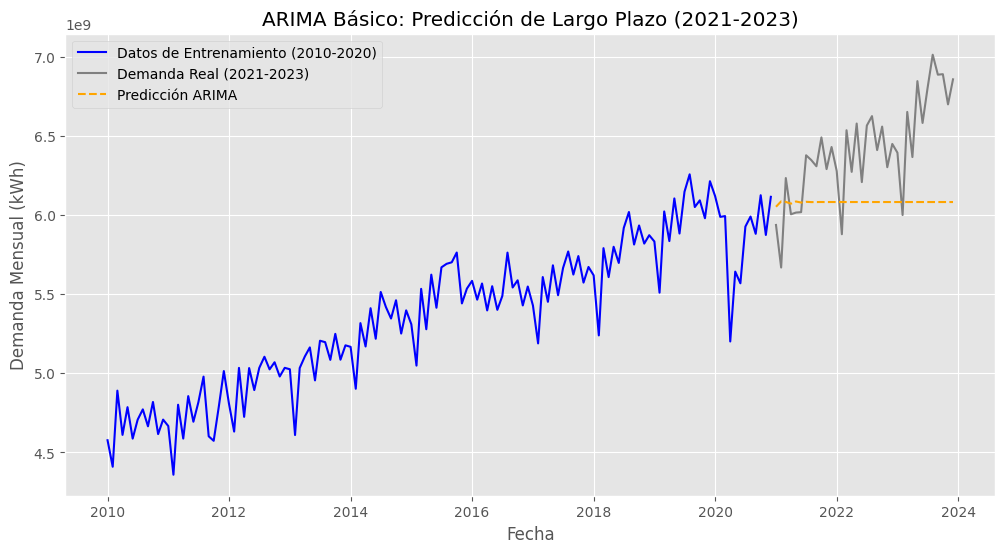


✅ ARIMAX (Con Exógenas) - EVALUACIÓN 2019
   MAE: 53,970,805 kWh
   RMSE: 66,176,096 kWh
   R²: 0.8871


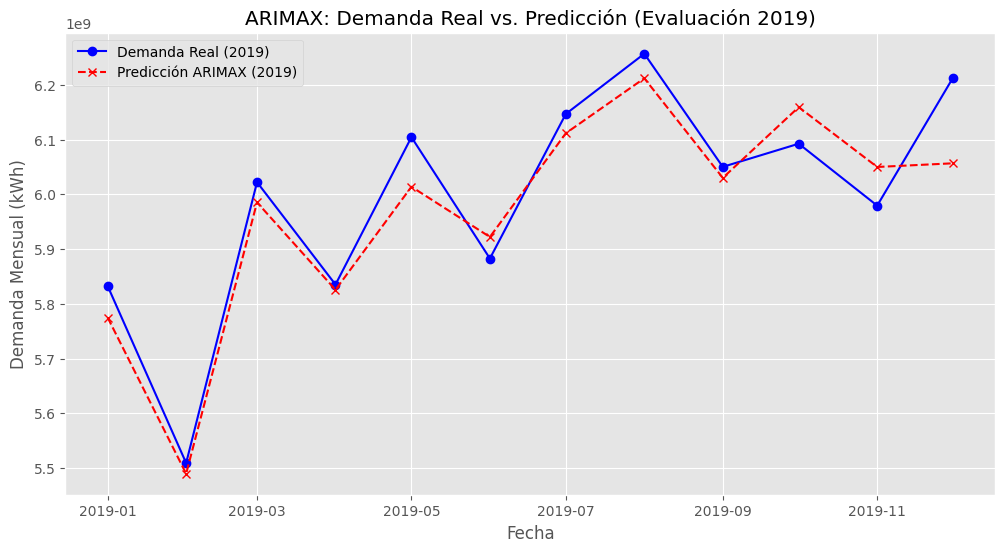


--- ¡MODELADO FINALIZADO! ---


In [16]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline # Para uso en Colab, no en el entorno del LLM

# --- IDs de los archivos compartidos en Google Drive ---
ID_DEMANDA = '1_z7pgh0LHKkG9pIfYsJuPPsjwgZiEbSR'
ID_PRECIPITACIONES = '1jjzoQZ-UHitWQVxdUm2AYrV1ReJICSRY'
URL_BASE = 'https://drive.google.com/uc?id='

def cargar_excel_desde_drive(file_id, nombre_archivo):
    """Carga un archivo XLSX desde un ID de Google Drive a un DataFrame."""
    try:
        url_descarga = f'{URL_BASE}{file_id}&export=download'

        print(f"--- Cargando {nombre_archivo} desde Drive ---")

        response = requests.get(url_descarga)

        if response.status_code == 200:
            # FIX CLAVE: Se usa pd.read_excel para manejar el formato nativo XLSX
            df = pd.read_excel(BytesIO(response.content))
            return df
        else:
            print(f"Error al descargar {nombre_archivo}. Código de estado: {response.status_code}")
            return None

    except Exception as e:
        print(f"Ocurrió un error al procesar {nombre_archivo}: {e}")
        return None

# =======================================================
# PARTE 1: CARGA Y PREPARACIÓN DE DATOS
# =======================================================
print("\n--- 1. INICIANDO CARGA Y PREPARACIÓN DE DATOS ---")

# 1. CARGA DE DATOS
df_demanda = cargar_excel_desde_drive(ID_DEMANDA, "Demanda de Energía")
df_precipitacion = cargar_excel_desde_drive(ID_PRECIPITACIONES, "Precipitaciones")

if df_demanda is None or df_precipitacion is None:
    raise ValueError("Error al cargar los DataFrames de Drive. Verifica los permisos de los IDs.")

# 2. PREPROCESAMIENTO Y UNIÓN DE DATOS
df_demanda['Fecha'] = pd.to_datetime(df_demanda['Fecha'])
df_demanda.set_index('Fecha', inplace=True)
df_demanda_mensual = df_demanda[['Demanda Energia SIN kWh', 'Generación kWh']].resample('MS').sum()
df_demanda_mensual.rename(columns={'Demanda Energia SIN kWh': 'Demanda_Mensual_kWh',
                                    'Generación kWh': 'Generacion_Mensual_kWh'}, inplace=True)

meses = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
df_precipitacion_melt = df_precipitacion.melt(id_vars=['AÑO'], value_vars=meses, var_name='Mes_Nombre', value_name='Precipitacion_mm')
mapa_meses = {nombre: i + 1 for i, nombre in enumerate(meses)}
df_precipitacion_melt['Mes'] = df_precipitacion_melt['Mes_Nombre'].map(mapa_meses)
df_precipitacion_melt['Fecha'] = pd.to_datetime(df_precipitacion_melt['AÑO'].astype(str) + '-' + df_precipitacion_melt['Mes'].astype(str) + '-01')
df_precipitacion_mensual = df_precipitacion_melt.groupby('Fecha')['Precipitacion_mm'].mean().to_frame()

df_final = df_demanda_mensual.merge(df_precipitacion_mensual, left_index=True, right_index=True, how='inner')

# 3. FEATURE ENGINEERING (LAGS) Y DIVISIÓN DE CONJUNTOS
df_final['Mes'] = df_final.index.month
df_final['Generacion_lag_12'] = df_final['Generacion_Mensual_kWh'].shift(12)
df_final['Demanda_lag_1'] = df_final['Demanda_Mensual_kWh'].shift(1)
df_final['Demanda_lag_12'] = df_final['Demanda_Mensual_kWh'].shift(12)
df_final['Precipitacion_lag_1'] = df_final['Precipitacion_mm'].shift(1)
df_final.dropna(inplace=True)

# División para ML/ARIMAX (Corte 2019)
fecha_corte_ml = '2019-01-01'
df_train = df_final[df_final.index < fecha_corte_ml]
variables_excluir = ['Demanda_Mensual_kWh', 'Generacion_Mensual_kWh', 'Precipitacion_mm']
X_train = df_train.drop(variables_excluir, axis=1)
Y_train = df_train['Demanda_Mensual_kWh']
df_test = df_final[df_final.index >= fecha_corte_ml]
X_test = df_test.drop(variables_excluir, axis=1)
Y_test = df_test['Demanda_Mensual_kWh']
X_test = X_test.iloc[0:12] # Solo 2019
Y_test = Y_test.iloc[0:12] # Solo 2019

# División para ARIMA Básico (Corte 2021)
fecha_corte_arima = '2021-01-01'
train_sarima = df_demanda_mensual[df_demanda_mensual.index < fecha_corte_arima]['Demanda_Mensual_kWh']
test_sarima = df_demanda_mensual[df_demanda_mensual.index >= fecha_corte_arima]['Demanda_Mensual_kWh']

print("\n--- Datos y Conjuntos de Entrenamiento/Prueba definidos con éxito. ---")
print("="*70)

# =======================================================
# PARTE 2: ARIMA BÁSICO (5, 1, 0) - Evaluación 2021-2023
# =======================================================
print("✅ ARIMA BÁSICO - EVALUACIÓN 2021-2023 (Largo Plazo)")
print("="*70)

try:
    # 1. Re-entrenamiento del Modelo ARIMA(5, 1, 0)
    arima_model = ARIMA(train_sarima, order=(5, 1, 0))
    arima_result = arima_model.fit()

    # 2. Predicción y Evaluación
    n_periods = len(test_sarima)
    forecast_arima = arima_result.forecast(steps=n_periods)
    prediccion_arima = pd.Series(forecast_arima, index=test_sarima.index)

    mae_arima = mean_absolute_error(test_sarima, prediccion_arima)
    rmse_arima = np.sqrt(mean_squared_error(test_sarima, prediccion_arima))
    r2_arima = r2_score(test_sarima, prediccion_arima)

    print(f"   MAE: {mae_arima:,.0f} kWh")
    print(f"   RMSE: {rmse_arima:,.0f} kWh")
    print(f"   R²: {r2_arima:.4f}")

    # 3. Visualización
    plt.figure(figsize=(12, 6))
    plt.plot(train_sarima.index, train_sarima, label='Datos de Entrenamiento (2010-2020)', color='blue')
    plt.plot(test_sarima.index, test_sarima, label='Demanda Real (2021-2023)', color='gray')
    plt.plot(prediccion_arima.index, prediccion_arima, label='Predicción ARIMA', linestyle='--', color='orange')
    plt.title('ARIMA Básico: Predicción de Largo Plazo (2021-2023)')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda Mensual (kWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error en ARIMA básico: {e}")

# =======================================================
# PARTE 3: ARIMAX (5, 1, 0) - Evaluación 2019
# =======================================================
print("\n" + "="*70)
print("✅ ARIMAX (Con Exógenas) - EVALUACIÓN 2019")
print("="*70)

try:
    # 1. Ajuste del Modelo ARIMAX usando SARIMAX
    arimax_model = SARIMAX(Y_train,
                           exog=X_train,
                           order=(5, 1, 0),
                           seasonal_order=(0, 0, 0, 0))
    arimax_result = arimax_model.fit(disp=False)

    # 2. Predicción y Evaluación
    Y_pred_arimax = arimax_result.forecast(steps=len(X_test), exog=X_test)

    mae_arimax = mean_absolute_error(Y_test, Y_pred_arimax)
    rmse_arimax = np.sqrt(mean_squared_error(Y_test, Y_pred_arimax))
    r2_arimax = r2_score(Y_test, Y_pred_arimax)

    print(f"   MAE: {mae_arimax:,.0f} kWh")
    print(f"   RMSE: {rmse_arimax:,.0f} kWh")
    print(f"   R²: {r2_arimax:.4f}")

    # 3. Visualización
    df_resultados_arimax = pd.DataFrame({
        'Real': Y_test,
        'Predicción ARIMAX': Y_pred_arimax
    }, index=Y_test.index)

    plt.figure(figsize=(12, 6))
    plt.plot(df_resultados_arimax.index, df_resultados_arimax['Real'],
             label='Demanda Real (2019)', marker='o', linestyle='-', color='blue')
    plt.plot(df_resultados_arimax.index, df_resultados_arimax['Predicción ARIMAX'],
             label='Predicción ARIMAX (2019)', marker='x', linestyle='--', color='red')
    plt.title('ARIMAX: Demanda Real vs. Predicción (Evaluación 2019)')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda Mensual (kWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error en ARIMAX: {e}")

print("\n--- ¡MODELADO FINALIZADO! ---")


--- 1. INICIANDO CARGA Y PREPARACIÓN DE DATOS ---
--- Cargando Demanda de Energía desde Drive ---
--- Cargando Precipitaciones desde Drive ---

--- Datos y Conjuntos de Entrenamiento/Prueba definidos con éxito. ---
✅ SARIMAX ESTACIONAL - EVALUACIÓN 2021-2023 (Largo Plazo)
   MAE: 753,056,697 kWh
   RMSE: 845,007,934 kWh
   R²: -6.2840


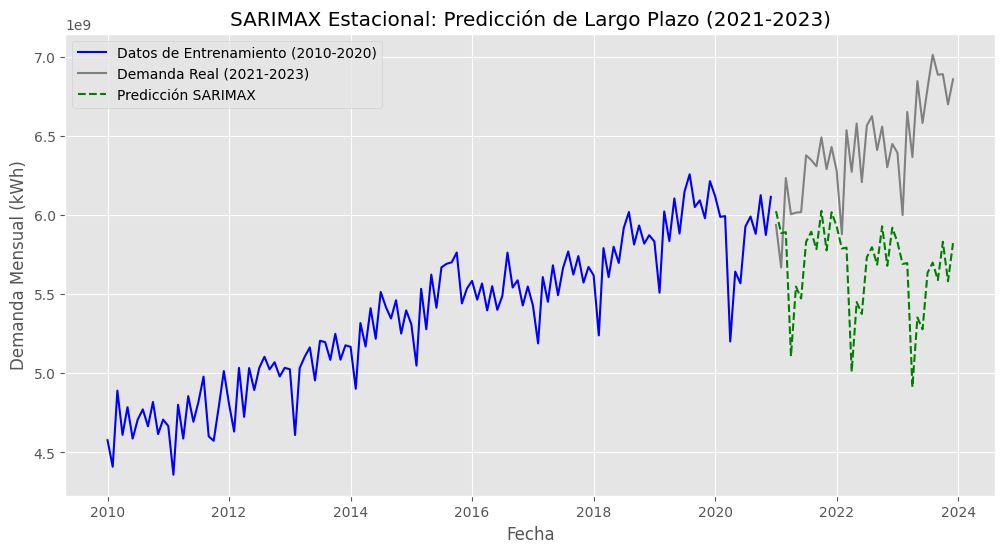


✅ ARIMAX (Con Exógenas) - EVALUACIÓN 2019
   MAE: 53,970,805 kWh
   RMSE: 66,176,096 kWh
   R²: 0.8871


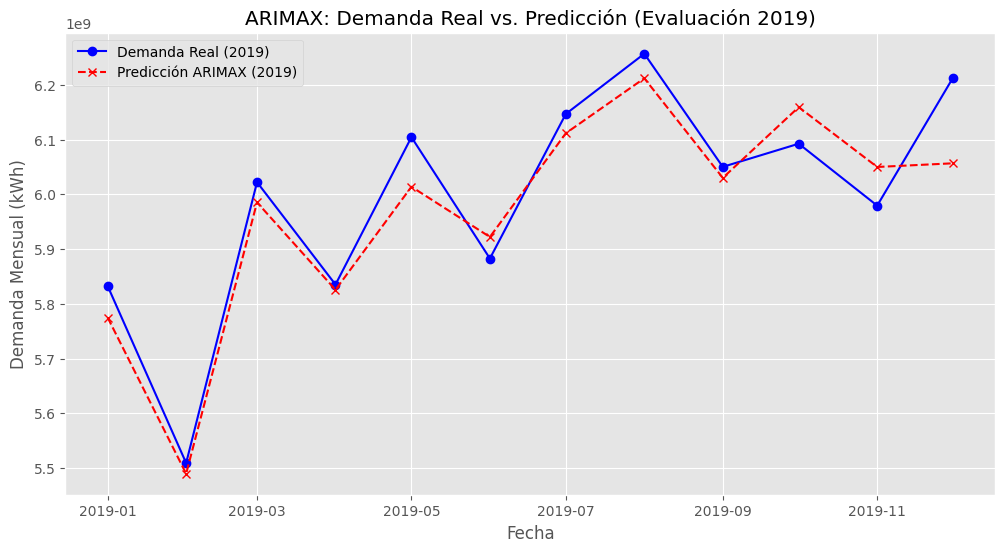


--- ¡MODELADO FINALIZADO! ---


In [17]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA # Todavía se necesita para el código base, aunque no se use para la predicción estacional
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline

# --- IDs de los archivos compartidos en Google Drive ---
# Usamos los IDs que confirmamos que cargan correctamente los archivos XLSX
ID_DEMANDA = '1_z7pgh0LHKkG9pIfYsJuPPsjwgZiEbSR'
ID_PRECIPITACIONES = '1jjzoQZ-UHitWQVxdUm2AYrV1ReJICSRY'
URL_BASE = 'https://drive.google.com/uc?id='

def cargar_excel_desde_drive(file_id, nombre_archivo):
    """Carga un archivo XLSX desde un ID de Google Drive a un DataFrame."""
    try:
        url_descarga = f'{URL_BASE}{file_id}&export=download'

        print(f"--- Cargando {nombre_archivo} desde Drive ---")

        response = requests.get(url_descarga)

        if response.status_code == 200:
            df = pd.read_excel(BytesIO(response.content))
            return df
        else:
            print(f"Error al descargar {nombre_archivo}. Código de estado: {response.status_code}")
            return None

    except Exception as e:
        print(f"Ocurrió un error al procesar {nombre_archivo}: {e}")
        return None

# =======================================================
# PARTE 1: CARGA Y PREPARACIÓN DE DATOS
# =======================================================
print("\n--- 1. INICIANDO CARGA Y PREPARACIÓN DE DATOS ---")

# 1. CARGA DE DATOS
df_demanda = cargar_excel_desde_drive(ID_DEMANDA, "Demanda de Energía")
df_precipitacion = cargar_excel_desde_drive(ID_PRECIPITACIONES, "Precipitaciones")

if df_demanda is None or df_precipitacion is None:
    raise ValueError("Error al cargar los DataFrames de Drive. Verifica los permisos de los IDs.")

# 2. PREPROCESAMIENTO Y UNIÓN DE DATOS
df_demanda['Fecha'] = pd.to_datetime(df_demanda['Fecha'])
df_demanda.set_index('Fecha', inplace=True)
df_demanda_mensual = df_demanda[['Demanda Energia SIN kWh', 'Generación kWh']].resample('MS').sum()
df_demanda_mensual.rename(columns={'Demanda Energia SIN kWh': 'Demanda_Mensual_kWh',
                                    'Generación kWh': 'Generacion_Mensual_kWh'}, inplace=True)

meses = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
df_precipitacion_melt = df_precipitacion.melt(id_vars=['AÑO'], value_vars=meses, var_name='Mes_Nombre', value_name='Precipitacion_mm')
mapa_meses = {nombre: i + 1 for i, nombre in enumerate(meses)}
df_precipitacion_melt['Mes'] = df_precipitacion_melt['Mes_Nombre'].map(mapa_meses)
df_precipitacion_melt['Fecha'] = pd.to_datetime(df_precipitacion_melt['AÑO'].astype(str) + '-' + df_precipitacion_melt['Mes'].astype(str) + '-01')
df_precipitacion_mensual = df_precipitacion_melt.groupby('Fecha')['Precipitacion_mm'].mean().to_frame()

df_final = df_demanda_mensual.merge(df_precipitacion_mensual, left_index=True, right_index=True, how='inner')

# 3. FEATURE ENGINEERING (LAGS) Y DIVISIÓN DE CONJUNTOS
df_final['Mes'] = df_final.index.month
df_final['Generacion_lag_12'] = df_final['Generacion_Mensual_kWh'].shift(12)
df_final['Demanda_lag_1'] = df_final['Demanda_Mensual_kWh'].shift(1)
df_final['Demanda_lag_12'] = df_final['Demanda_Mensual_kWh'].shift(12)
df_final['Precipitacion_lag_1'] = df_final['Precipitacion_mm'].shift(1)
df_final.dropna(inplace=True)

# División para ML/ARIMAX (Corte 2019)
fecha_corte_ml = '2019-01-01'
df_train = df_final[df_final.index < fecha_corte_ml]
variables_excluir = ['Demanda_Mensual_kWh', 'Generacion_Mensual_kWh', 'Precipitacion_mm']
X_train = df_train.drop(variables_excluir, axis=1)
Y_train = df_train['Demanda_Mensual_kWh']
df_test = df_final[df_final.index >= fecha_corte_ml]
X_test = df_test.drop(variables_excluir, axis=1)
Y_test = df_test['Demanda_Mensual_kWh']
X_test = X_test.iloc[0:12] # Solo 2019
Y_test = Y_test.iloc[0:12] # Solo 2019

# División para ARIMA Básico y SARIMAX (Corte 2021)
fecha_corte_arima = '2021-01-01'
train_sarima = df_demanda_mensual[df_demanda_mensual.index < fecha_corte_arima]['Demanda_Mensual_kWh']
test_sarima = df_demanda_mensual[df_demanda_mensual.index >= fecha_corte_arima]['Demanda_Mensual_kWh']

print("\n--- Datos y Conjuntos de Entrenamiento/Prueba definidos con éxito. ---")
print("="*70)

# =======================================================
# PARTE 2: SARIMAX ESTACIONAL (5, 1, 0)x(0, 1, 1)12 - Evaluación 2021-2023
# =======================================================
print("✅ SARIMAX ESTACIONAL - EVALUACIÓN 2021-2023 (Largo Plazo)")
print("="*70)

try:
    # 1. Ajuste del Modelo SARIMAX(5, 1, 0)x(0, 1, 1)12
    # El (0, 1, 1)12 aplica diferenciación estacional D=1 (clave)
    sarimax_model = SARIMAX(train_sarima,
                           order=(5, 1, 0),
                           seasonal_order=(0, 1, 1, 12))
    sarimax_result = sarimax_model.fit(disp=False)

    # 2. Predicción y Evaluación
    n_periods = len(test_sarima)
    # forecast funciona igual en SARIMAX cuando no hay exógenas
    forecast_sarimax = sarimax_result.forecast(steps=n_periods)
    prediccion_sarimax = pd.Series(forecast_sarimax, index=test_sarima.index)

    mae_sarimax = mean_absolute_error(test_sarima, prediccion_sarimax)
    rmse_sarimax = np.sqrt(mean_squared_error(test_sarima, prediccion_sarimax))
    r2_sarimax = r2_score(test_sarima, prediccion_sarimax)

    print(f"   MAE: {mae_sarimax:,.0f} kWh")
    print(f"   RMSE: {rmse_sarimax:,.0f} kWh")
    print(f"   R²: {r2_sarimax:.4f}")

    # 3. Visualización
    plt.figure(figsize=(12, 6))
    plt.plot(train_sarima.index, train_sarima, label='Datos de Entrenamiento (2010-2020)', color='blue')
    plt.plot(test_sarima.index, test_sarima, label='Demanda Real (2021-2023)', color='gray')
    plt.plot(prediccion_sarimax.index, prediccion_sarimax, label='Predicción SARIMAX', linestyle='--', color='green')
    plt.title('SARIMAX Estacional: Predicción de Largo Plazo (2021-2023)')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda Mensual (kWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error en SARIMAX Estacional: {e}")

# =======================================================
# PARTE 3: ARIMAX (5, 1, 0) - Evaluación 2019 (Mantenido)
# =======================================================
print("\n" + "="*70)
print("✅ ARIMAX (Con Exógenas) - EVALUACIÓN 2019")
print("="*70)

try:
    # 1. Ajuste del Modelo ARIMAX usando SARIMAX (con exógenas, sin estacionalidad)
    arimax_model = SARIMAX(Y_train,
                           exog=X_train,
                           order=(5, 1, 0),
                           seasonal_order=(0, 0, 0, 0))
    arimax_result = arimax_model.fit(disp=False)

    # 2. Predicción y Evaluación
    Y_pred_arimax = arimax_result.forecast(steps=len(X_test), exog=X_test)

    mae_arimax = mean_absolute_error(Y_test, Y_pred_arimax)
    rmse_arimax = np.sqrt(mean_squared_error(Y_test, Y_pred_arimax))
    r2_arimax = r2_score(Y_test, Y_pred_arimax)

    print(f"   MAE: {mae_arimax:,.0f} kWh")
    print(f"   RMSE: {rmse_arimax:,.0f} kWh")
    print(f"   R²: {r2_arimax:.4f}")

    # 3. Visualización
    df_resultados_arimax = pd.DataFrame({
        'Real': Y_test,
        'Predicción ARIMAX': Y_pred_arimax
    }, index=Y_test.index)

    plt.figure(figsize=(12, 6))
    plt.plot(df_resultados_arimax.index, df_resultados_arimax['Real'],
             label='Demanda Real (2019)', marker='o', linestyle='-', color='blue')
    plt.plot(df_resultados_arimax.index, df_resultados_arimax['Predicción ARIMAX'],
             label='Predicción ARIMAX (2019)', marker='x', linestyle='--', color='red')
    plt.title('ARIMAX: Demanda Real vs. Predicción (Evaluación 2019)')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda Mensual (kWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error en ARIMAX: {e}")

print("\n--- ¡MODELADO FINALIZADO! ---")

--- Datos listos para ML y Series de Tiempo. ---
✅ RANDOM FOREST - EVALUACIÓN 2019
   MAE: 160,575,321 kWh
   RMSE: 198,263,171 kWh
   R²: -0.0136


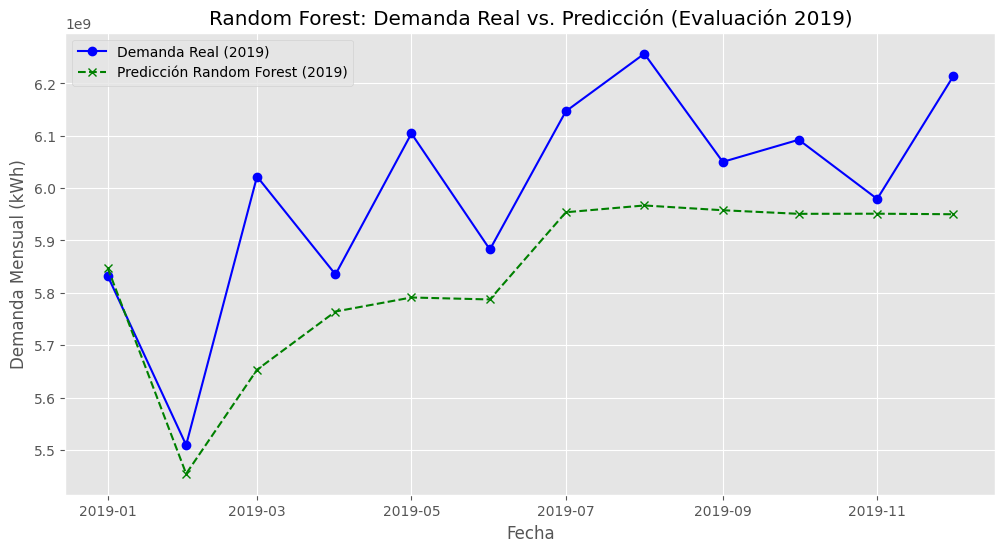


✅ GRADIENT BOOSTING - EVALUACIÓN 2019
   MAE: 156,412,706 kWh
   RMSE: 192,095,846 kWh
   R²: 0.0484


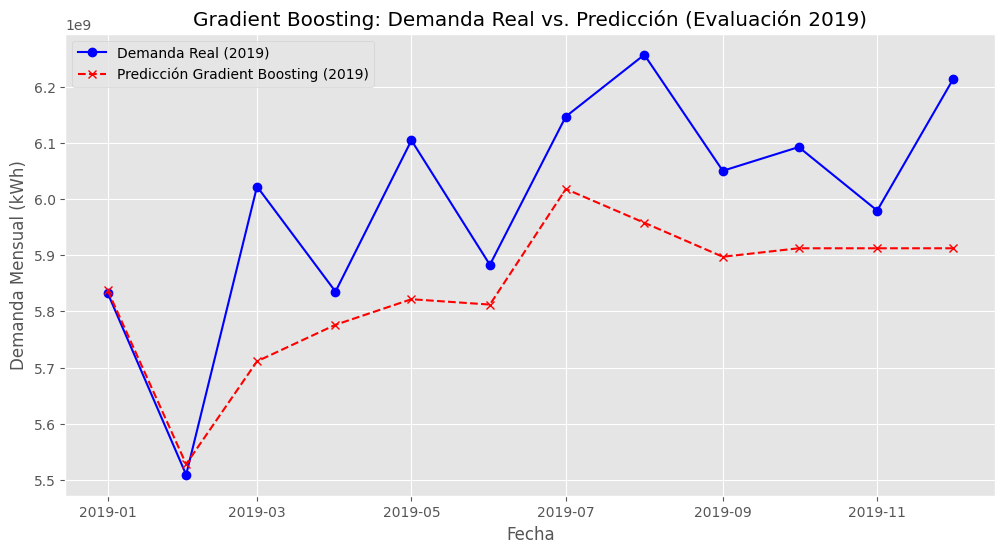


--- ¡MODELOS ML EVALUADOS! ---


In [18]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

# --- IDs de los archivos compartidos en Google Drive ---
ID_DEMANDA = '1_z7pgh0LHKkG9pIfYsJuPPsjwgZiEbSR'
ID_PRECIPITACIONES = '1jjzoQZ-UHitWQVxdUm2AYrV1ReJICSRY'
URL_BASE = 'https://drive.google.com/uc?id='

def cargar_excel_desde_drive(file_id, nombre_archivo):
    """Carga un archivo XLSX desde un ID de Google Drive a un DataFrame."""
    try:
        url_descarga = f'{URL_BASE}{file_id}&export=download'

        response = requests.get(url_descarga)

        if response.status_code == 200:
            df = pd.read_excel(BytesIO(response.content))
            return df
        else:
            return None

    except Exception:
        return None

# =======================================================
# PARTE 1: CARGA Y PREPARACIÓN DE DATOS
# (Se asume que esta sección ya fue ejecutada con éxito)
# =======================================================

# 1. CARGA DE DATOS
df_demanda = cargar_excel_desde_drive(ID_DEMANDA, "Demanda de Energía")
df_precipitacion = cargar_excel_desde_drive(ID_PRECIPITACIONES, "Precipitaciones")

if df_demanda is None or df_precipitacion is None:
    print("Error al cargar datos. Asegúrate de que los IDs son correctos y accesibles.")
    # Usar un raise evita ejecutar el resto si la carga falla
    raise ValueError("Error de carga de datos.")

# 2. PREPROCESAMIENTO Y UNIÓN DE DATOS (Mismo código de preparación)
df_demanda['Fecha'] = pd.to_datetime(df_demanda['Fecha'])
df_demanda.set_index('Fecha', inplace=True)
df_demanda_mensual = df_demanda[['Demanda Energia SIN kWh', 'Generación kWh']].resample('MS').sum()
df_demanda_mensual.rename(columns={'Demanda Energia SIN kWh': 'Demanda_Mensual_kWh',
                                    'Generación kWh': 'Generacion_Mensual_kWh'}, inplace=True)

meses = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
df_precipitacion_melt = df_precipitacion.melt(id_vars=['AÑO'], value_vars=meses, var_name='Mes_Nombre', value_name='Precipitacion_mm')
mapa_meses = {nombre: i + 1 for i, nombre in enumerate(meses)}
df_precipitacion_melt['Mes'] = df_precipitacion_melt['Mes_Nombre'].map(mapa_meses)
df_precipitacion_melt['Fecha'] = pd.to_datetime(df_precipitacion_melt['AÑO'].astype(str) + '-' + df_precipitacion_melt['Mes'].astype(str) + '-01')
df_precipitacion_mensual = df_precipitacion_melt.groupby('Fecha')['Precipitacion_mm'].mean().to_frame()

df_final = df_demanda_mensual.merge(df_precipitacion_mensual, left_index=True, right_index=True, how='inner')

# 3. FEATURE ENGINEERING (Lags) Y DIVISIÓN DE CONJUNTOS (Corte 2019)
df_final['Mes'] = df_final.index.month
df_final['Generacion_lag_12'] = df_final['Generacion_Mensual_kWh'].shift(12)
df_final['Demanda_lag_1'] = df_final['Demanda_Mensual_kWh'].shift(1)
df_final['Demanda_lag_12'] = df_final['Demanda_Mensual_kWh'].shift(12)
df_final['Precipitacion_lag_1'] = df_final['Precipitacion_mm'].shift(1)
df_final.dropna(inplace=True)

fecha_corte_ml = '2019-01-01'
df_train = df_final[df_final.index < fecha_corte_ml]
variables_excluir = ['Demanda_Mensual_kWh', 'Generacion_Mensual_kWh', 'Precipitacion_mm']
X_train = df_train.drop(variables_excluir, axis=1)
Y_train = df_train['Demanda_Mensual_kWh']
df_test = df_final[df_final.index >= fecha_corte_ml]
X_test = df_test.drop(variables_excluir, axis=1)
Y_test = df_test['Demanda_Mensual_kWh']
X_test = X_test.iloc[0:12]
Y_test = Y_test.iloc[0:12]

print("--- Datos listos para ML y Series de Tiempo. ---")
print("="*70)

# =======================================================
# PARTE 2: MODELO DE MACHINE LEARNING: RANDOM FOREST
# =======================================================
print("✅ RANDOM FOREST - EVALUACIÓN 2019")
print("="*70)

try:
    # 1. Ajuste del Modelo Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, Y_train)

    # 2. Predicción y Evaluación
    Y_pred_rf = rf_model.predict(X_test)

    mae_rf = mean_absolute_error(Y_test, Y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(Y_test, Y_pred_rf))
    r2_rf = r2_score(Y_test, Y_pred_rf)

    print(f"   MAE: {mae_rf:,.0f} kWh")
    print(f"   RMSE: {rmse_rf:,.0f} kWh")
    print(f"   R²: {r2_rf:.4f}")

    # 3. Visualización
    df_resultados_rf = pd.DataFrame({'Real': Y_test, 'Predicción RF': Y_pred_rf}, index=Y_test.index)
    plt.figure(figsize=(12, 6))
    plt.plot(df_resultados_rf.index, df_resultados_rf['Real'], label='Demanda Real (2019)', marker='o', linestyle='-', color='blue')
    plt.plot(df_resultados_rf.index, df_resultados_rf['Predicción RF'], label='Predicción Random Forest (2019)', marker='x', linestyle='--', color='green')
    plt.title('Random Forest: Demanda Real vs. Predicción (Evaluación 2019)')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda Mensual (kWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error en Random Forest: {e}")

# =======================================================
# PARTE 3: MODELO DE MACHINE LEARNING: GRADIENT BOOSTING
# =======================================================
print("\n" + "="*70)
print("✅ GRADIENT BOOSTING - EVALUACIÓN 2019")
print("="*70)

try:
    # 1. Ajuste del Modelo Gradient Boosting
    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    gb_model.fit(X_train, Y_train)

    # 2. Predicción y Evaluación
    Y_pred_gb = gb_model.predict(X_test)

    mae_gb = mean_absolute_error(Y_test, Y_pred_gb)
    rmse_gb = np.sqrt(mean_squared_error(Y_test, Y_pred_gb))
    r2_gb = r2_score(Y_test, Y_pred_gb)

    print(f"   MAE: {mae_gb:,.0f} kWh")
    print(f"   RMSE: {rmse_gb:,.0f} kWh")
    print(f"   R²: {r2_gb:.4f}")

    # 3. Visualización
    df_resultados_gb = pd.DataFrame({'Real': Y_test, 'Predicción GB': Y_pred_gb}, index=Y_test.index)
    plt.figure(figsize=(12, 6))
    plt.plot(df_resultados_gb.index, df_resultados_gb['Real'], label='Demanda Real (2019)', marker='o', linestyle='-', color='blue')
    plt.plot(df_resultados_gb.index, df_resultados_gb['Predicción GB'], label='Predicción Gradient Boosting (2019)', marker='x', linestyle='--', color='red')
    plt.title('Gradient Boosting: Demanda Real vs. Predicción (Evaluación 2019)')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda Mensual (kWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error en Gradient Boosting: {e}")

print("\n--- ¡MODELOS ML EVALUADOS! ---")

--- 1. CARGANDO Y PREPARANDO DATOS FINALES ---
--- Cargando Demanda de Energía ---
--- Cargando Precipitaciones ---
Datos de entrenamiento ML/ARIMAX completos: 2011 a 2019
--- Proyección Recursiva de 132 pasos (hasta 2030) iniciada, usando 2019 como patrón de exógenas. ---
--- 3.1 SARIMAX Estacional (Base) ---
--- 3.2 Entrenamiento final de Modelos Recursivos ---
--- 3.3 Ejecución de Pronóstico Recursivo ---

--- ¡PROYECCIÓN A 2030 FINALIZADA! ---


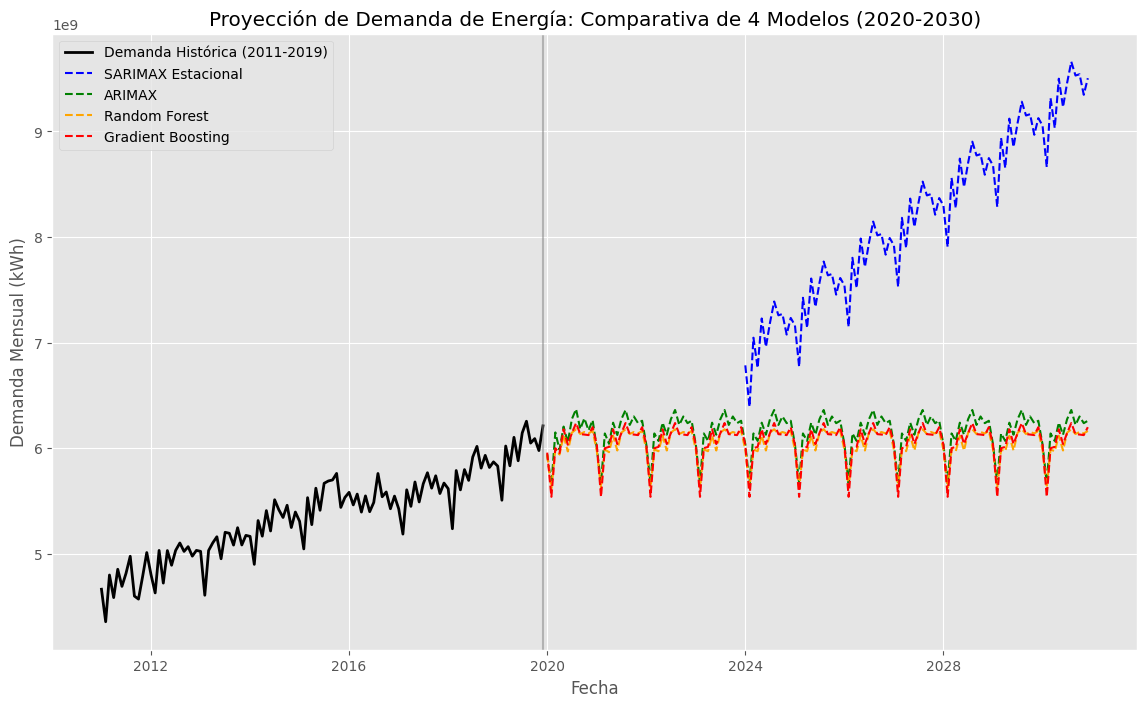


TABLA DE PROYECCIONES FINALES (Primeros y Últimos Meses)
----------------------------------------------------------
            SARIMAX        ARIMAX  Random Forest  Gradient Boosting
2020-01-01      NaN  5.943104e+09   5.938935e+09       5.959557e+09
2020-02-01      NaN  5.653391e+09   5.622084e+09       5.541385e+09
2020-03-01      NaN  6.150699e+09   5.989170e+09       6.001985e+09
2020-04-01      NaN  5.987466e+09   5.941791e+09       5.955467e+09
2020-05-01      NaN  6.206431e+09   6.122122e+09       6.180656e+09
...
                 SARIMAX        ARIMAX  Random Forest  Gradient Boosting
2030-08-01  9.660278e+09  6.363383e+09   6.180904e+09       6.239942e+09
2030-09-01  9.529509e+09  6.221929e+09   6.136372e+09       6.134677e+09
2030-10-01  9.541636e+09  6.302012e+09   6.154873e+09       6.130960e+09
2030-11-01  9.347016e+09  6.238758e+09   6.141785e+09       6.125659e+09
2030-12-01  9.504596e+09  6.261326e+09   6.164646e+09       6.200610e+09


In [27]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

# --- IDs de los archivos compartidos en Google Drive ---
ID_DEMANDA = '1_z7pgh0LHKkG9pIfYsJuPPsjwgZiEbSR'
ID_PRECIPITACIONES = '1jjzoQZ-UHitWQVxdUm2AYrV1ReJICSRY'
URL_BASE = 'https://drive.google.com/uc?id='

# FUNCIÓN DE CARGA VALIDADA
def cargar_excel_desde_drive(file_id, nombre_archivo):
    """Carga un archivo XLSX desde un ID de Google Drive a un DataFrame."""
    try:
        url_descarga = f'{URL_BASE}{file_id}&export=download'
        print(f"--- Cargando {nombre_archivo} ---")
        response = requests.get(url_descarga)

        if response.status_code == 200:
            df = pd.read_excel(BytesIO(response.content))
            return df
        else:
            print(f"Error al descargar {nombre_archivo}. Código de estado: {response.status_code}")
            return None
    except Exception as e:
        print(f"Ocurrió un error al procesar {nombre_archivo}: {e}")
        return None

# =======================================================
# PARTE 1: CARGA, PREPARACIÓN Y ENTRENAMIENTO FINAL
# =======================================================
print("--- 1. CARGANDO Y PREPARANDO DATOS FINALES ---")

# 1. CARGA DE DATOS
df_demanda = cargar_excel_desde_drive(ID_DEMANDA, "Demanda de Energía")
df_precipitacion = cargar_excel_desde_drive(ID_PRECIPITACIONES, "Precipitaciones")

if df_demanda is None or df_precipitacion is None:
    raise ValueError("Error CRÍTICO: La carga de al menos uno de los DataFrames de Google Drive falló. Verifique los IDs y los permisos del archivo.")

# 2. PREPROCESAMIENTO Y UNIÓN DE DATOS
df_demanda['Fecha'] = pd.to_datetime(df_demanda['Fecha'])
df_demanda.set_index('Fecha', inplace=True)
df_demanda_mensual = df_demanda[['Demanda Energia SIN kWh', 'Generación kWh']].resample('MS').sum()
df_demanda_mensual.rename(columns={'Demanda Energia SIN kWh': 'Demanda_Mensual_kWh',
                                    'Generación kWh': 'Generacion_Mensual_kWh'}, inplace=True)

meses = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
df_precipitacion_melt = df_precipitacion.melt(id_vars=['AÑO'], value_vars=meses, var_name='Mes_Nombre', value_name='Precipitacion_mm')
mapa_meses = {nombre: i + 1 for i, nombre in enumerate(meses)}
df_precipitacion_melt['Mes'] = df_precipitacion_melt['Mes_Nombre'].map(mapa_meses)
df_precipitacion_melt['Fecha'] = pd.to_datetime(df_precipitacion_melt['AÑO'].astype(str) + '-' + df_precipitacion_melt['Mes'].astype(str) + '-01')
df_precipitacion_mensual = df_precipitacion_melt.groupby('Fecha')['Precipitacion_mm'].mean().to_frame()

df_base = df_demanda_mensual.merge(df_precipitacion_mensual, left_index=True, right_index=True, how='inner')

# 3. FEATURE ENGINEERING (Lags)
df_base['Mes'] = df_base.index.month
df_base['Generacion_lag_12'] = df_base['Generacion_Mensual_kWh'].shift(12)
df_base['Demanda_lag_1'] = df_base['Demanda_Mensual_kWh'].shift(1)
df_base['Demanda_lag_12'] = df_base['Demanda_Mensual_kWh'].shift(12)
df_base['Precipitacion_lag_1'] = df_base['Precipitacion_mm'].shift(1)
df_base.dropna(inplace=True)

# Determinación de los conjuntos de entrenamiento
X_train_full = df_base.drop(['Demanda_Mensual_kWh', 'Generacion_Mensual_kWh', 'Precipitacion_mm'], axis=1)
Y_train_full = df_base['Demanda_Mensual_kWh']
train_sarima_full = df_demanda_mensual['Demanda_Mensual_kWh']
FEATURE_NAMES = X_train_full.columns.tolist() # <--- CAPTURAR EL ORDEN DE LAS COLUMNAS

LAST_TRAIN_DATE = Y_train_full.index.max()
PROJECTION_BASE_YEAR = LAST_TRAIN_DATE.year

print(f"Datos de entrenamiento ML/ARIMAX completos: {Y_train_full.index.min().year} a {PROJECTION_BASE_YEAR}")

# =======================================================
# PARTE 2: DEFINICIÓN DE PROYECCIÓN FUTURA (2020-2030)
# =======================================================

# 1. Definición del Periodo Futuro
start_future = LAST_TRAIN_DATE + pd.DateOffset(months=1)
end_future = pd.to_datetime('2030-12-01')
future_dates = pd.date_range(start=start_future, end=end_future, freq='MS')
n_periods = len(future_dates)

# 2. Proyección de Variables Exógenas (Patrón del último año completo en df_base: 2019)
df_base_year = df_base[df_base.index.year == PROJECTION_BASE_YEAR]

if len(df_base_year) < 12:
    raise ValueError(f"Error: El último año completo de entrenamiento ({PROJECTION_BASE_YEAR}) tiene menos de 12 meses. Revise sus datos.")

last_generacion_12_months = df_base_year['Generacion_lag_12'].values
last_precipitacion_1_months = df_base_year['Precipitacion_lag_1'].values

# Construimos el DataFrame futuro (X_future)
X_future = pd.DataFrame(index=future_dates)
X_future['Mes'] = X_future.index.month

# Aplicamos el patrón del año base repetido (132 pasos)
X_future['Generacion_lag_12'] = np.tile(last_generacion_12_months, n_periods // 12 + 1)[:n_periods]
X_future['Precipitacion_lag_1'] = np.tile(last_precipitacion_1_months, n_periods // 12 + 1)[:n_periods]

# Inicializamos Demanda_lag_1 y Demanda_lag_12
X_future['Demanda_lag_1'] = np.nan
X_future['Demanda_lag_12'] = np.nan

# Llenamos los primeros lags con los valores reales finales (conocidos)
X_future.loc[X_future.index[0], 'Demanda_lag_1'] = Y_train_full.iloc[-1]
X_future.loc[X_future.index[0], 'Demanda_lag_12'] = Y_train_full.iloc[-12]

print(f"--- Proyección Recursiva de {n_periods} pasos (hasta 2030) iniciada, usando {PROJECTION_BASE_YEAR} como patrón de exógenas. ---")
print("="*70)

# =======================================================
# PARTE 3: ENTRENAMIENTO Y PRONÓSTICO DE LOS 4 MODELOS
# =======================================================

# Almacenamiento de Predicciones
forecasts = pd.DataFrame(index=future_dates)

# --- 3.1 SARIMAX Estacional (No Recursivo) ---
print("--- 3.1 SARIMAX Estacional (Base) ---")
sarimax_model = SARIMAX(train_sarima_full, order=(5, 1, 0), seasonal_order=(0, 1, 1, 12))
sarimax_result = sarimax_model.fit(disp=False)
forecasts['SARIMAX'] = sarimax_result.forecast(steps=n_periods)

# --- 3.2 Modelos Recursivos (ARIMAX, RF, GB) ---
print("--- 3.2 Entrenamiento final de Modelos Recursivos ---")

# 1. ENTRENAMIENTO FINAL
arimax_model = SARIMAX(Y_train_full, exog=X_train_full, order=(5, 1, 0), seasonal_order=(0, 0, 0, 0))
arimax_result = arimax_model.fit(disp=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_full, Y_train_full)

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_full, Y_train_full)

# 2. Pronóstico Recursivo
print("--- 3.3 Ejecución de Pronóstico Recursivo ---")

X_future_recursive = X_future.copy()
Y_pred_arimax_recursive = np.zeros(n_periods)
Y_pred_rf_recursive = np.zeros(n_periods)
Y_pred_gb_recursive = np.zeros(n_periods)

# Almacenar los últimos 12 valores reales para lags
last_12_real = Y_train_full.iloc[-12:].values

for t in range(n_periods):

    # 1. Preparar features para el tiempo t
    current_X = X_future_recursive.iloc[t].to_frame().T
    # CORRECCIÓN CLAVE: Reordenar las columnas de current_X para que coincidan con FEATURE_NAMES
    current_X = current_X[FEATURE_NAMES]

    # 2. Predicción de los 3 modelos
    Y_pred_arimax_recursive[t] = arimax_result.forecast(steps=1, exog=current_X)[0]
    Y_pred_rf_recursive[t] = rf_model.predict(current_X)[0]
    Y_pred_gb_recursive[t] = gb_model.predict(current_X)[0]

    # 3. Actualizar Lags para el siguiente paso (t+1)
    if t < n_periods - 1:

        # Demanda_lag_1 (Demanda del mes anterior)
        # Usamos la predicción del Gradient Boosting (el mejor modelo en 2019)
        next_demanda_lag_1 = Y_pred_gb_recursive[t]
        X_future_recursive.loc[X_future_recursive.index[t+1], 'Demanda_lag_1'] = next_demanda_lag_1

        # Demanda_lag_12 (Demanda del mismo mes del año anterior)
        if t + 1 < 12:
            # Primer año de pronóstico (2020), usamos los valores reales de 2019
            next_demanda_lag_12 = last_12_real[t + 1]
        else:
            # A partir del segundo año (2021), usamos la predicción de hace 12 meses
            next_demanda_lag_12 = Y_pred_gb_recursive[t + 1 - 12]

        X_future_recursive.loc[X_future_recursive.index[t+1], 'Demanda_lag_12'] = next_demanda_lag_12

forecasts['ARIMAX'] = pd.Series(Y_pred_arimax_recursive, index=future_dates)
forecasts['Random Forest'] = pd.Series(Y_pred_rf_recursive, index=future_dates)
forecasts['Gradient Boosting'] = pd.Series(Y_pred_gb_recursive, index=future_dates)

print("\n--- ¡PROYECCIÓN A 2030 FINALIZADA! ---")
print("="*70)

# =======================================================
# PARTE 4: VISUALIZACIÓN DE LA PROYECCIÓN FINAL
# =======================================================

plt.figure(figsize=(14, 8))

# Datos Históricos (todos los datos de entrenamiento hasta 2019)
plt.plot(Y_train_full.index, Y_train_full, label='Demanda Histórica (2011-2019)', color='black', linewidth=2)

# Proyecciones a 2030
plt.plot(forecasts.index, forecasts['SARIMAX'], label='SARIMAX Estacional', linestyle='--', color='blue')
plt.plot(forecasts.index, forecasts['ARIMAX'], label='ARIMAX', linestyle='--', color='green')
plt.plot(forecasts.index, forecasts['Random Forest'], label='Random Forest', linestyle='--', color='orange')
plt.plot(forecasts.index, forecasts['Gradient Boosting'], label='Gradient Boosting', linestyle='--', color='red')

plt.title('Proyección de Demanda de Energía: Comparativa de 4 Modelos (2020-2030)')
plt.xlabel('Fecha')
plt.ylabel('Demanda Mensual (kWh)')
plt.axvline(x=Y_train_full.index.max(), color='gray', linestyle='-', alpha=0.5)
plt.legend()
plt.grid(True)
plt.show()

# Resumen de los primeros y últimos 5 valores proyectados
print("\nTABLA DE PROYECCIONES FINALES (Primeros y Últimos Meses)")
print("----------------------------------------------------------")
print(forecasts.head())
print("...")
print(forecasts.tail())